In [1]:
import datetime
import sys
import os
import torch
import numpy as np
import random
from pathlib import Path
from collections import namedtuple
from miditok import REMIPlus, MMM
from miditok.constants import ADDITIONAL_TOKENS
from torch.nn import functional as F
from importlib import reload

In [2]:
import re

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CTX_LEN = 1024
PRECISION = 'bf16'

os.environ['RWKV_T_MAX'] = str(CTX_LEN)
os.environ['RWKV_FLOAT_MODE'] = PRECISION

os.chdir(re.sub(r'^(.*musai)\b.*$', '\\1', os.getcwd()))

sys.path.append('./src/model')
sys.path.append('./src/tools')

os.getcwd()

'/media/nico/data/projects/ai/musai'

In [3]:
DEVICE

device(type='cuda', index=0)

In [4]:
from runner import RWKV_RNN

In [5]:
PROJ_NAME = 'drum-bass-minreq'
IS_BPE = False
TOKENS_PATH = f"/home/nico/data/ai/models/midi/{PROJ_NAME}{'/bpe' if IS_BPE else ''}"

Path(f'./out/{PROJ_NAME}').mkdir(parents=True, exist_ok=True)

BINS_VELOCITY = (24)
BINS_TEMPO = (24)

additional_tokens = ADDITIONAL_TOKENS
additional_tokens['Chord'] = True
additional_tokens['TimeSignature'] = True
additional_tokens['Program'] = True
additional_tokens['nb_tempos'] = BINS_TEMPO
TOKENIZER = MMM(
    additional_tokens=additional_tokens, 
    params=f'{TOKENS_PATH}/token_params.cfg',
    nb_velocities=BINS_VELOCITY
)

ORIG_VOCAB_SIZE = len(TOKENIZER.vocab)
BPE_VOCAB_SIZE = int(ORIG_VOCAB_SIZE * 1.25)

(ORIG_VOCAB_SIZE, BPE_VOCAB_SIZE, len(TOKENIZER))

(517, 646, 517)

In [7]:
N_EMBED = 1024
N_LAYER = 24

params = {
    'ctx_len': CTX_LEN,
    'n_embd': N_EMBED,
    'n_layer': N_LAYER,
}

params_obj = namedtuple('RWKVParams', params.keys())(*params.values())

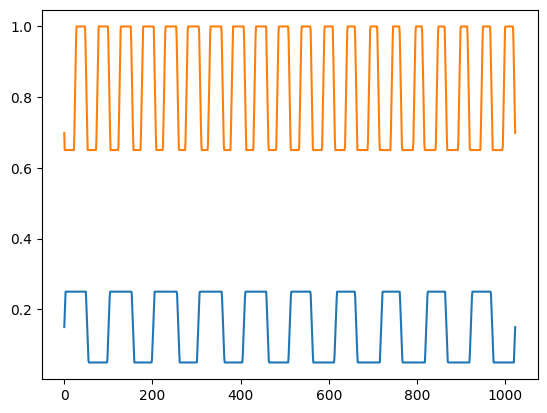

In [8]:
import matplotlib.pyplot as plt

MAX_ITER = CTX_LEN

# this is where we introduce some randomness
NOISE_LEVEL = 0.55
NOISE_FREQ = 10
PHASE = 0


def gen_sin_wave(total_iterations, min_value, max_value, noise_scale, noise_frequency, main_phase):
    """
    Generate a sinusoidal wave with optional noise.

    Args:
        total_iterations (int): The total number of iterations.
        min_value (float): The minimum value of the wave.
        max_value (float): The maximum value of the wave.
        noise_scale (float): The scale factor for the noise.
        noise_frequency (float): The frequency of the noise wave.
        main_phase (float): The phase of the main wave.

    Returns:
        list: A list of generated wave values.

    """
    progress = np.linspace(0, 1, total_iterations)
    main_wave = np.sin(2 * np.pi * progress + main_phase)
    noise_wave = np.sin(2 * np.pi * noise_frequency * progress - main_phase / 2)
    noise = noise_scale * noise_wave
    values = min_value + (max_value - min_value) * \
        (1 + main_wave) / 2 + noise

    np.clip(values, min_value, max_value, out=values)

    return values.tolist()


temp_values = gen_sin_wave(MAX_ITER, 0.05, 0.25, NOISE_LEVEL, NOISE_FREQ, PHASE)
top_p_values = gen_sin_wave(MAX_ITER, 0.65, 0.999, NOISE_LEVEL, NOISE_FREQ*2, PHASE+6)

plt.plot(temp_values)
plt.plot(top_p_values)

In [9]:
import types

SEED = random.randint(1000, 10000)
np.random.seed(SEED)

args = types.SimpleNamespace()
args.RUN_DEVICE = "cuda"
args.FLOAT_MODE = PRECISION
args.map_location = 'cpu'
args.base_model = f'/home/nico/dev/projects/ai/musai/out/{PROJ_NAME}/rwkv-12'
args.n_layer = params['n_layer']
args.n_embd = params['n_embd']
args.ctx_len = int(params['ctx_len'])

model_rnn = RWKV_RNN(args)
model_rnn.to(DEVICE)

copy_mask                                bfloat16   cuda:0
emb.weight                               bfloat16   cpu
blocks.0.ln1.weight                      bfloat16   cuda:0
blocks.0.ln1.bias                        bfloat16   cuda:0
blocks.0.ln2.weight                      bfloat16   cuda:0
blocks.0.ln2.bias                        bfloat16   cuda:0
blocks.0.ln0.weight                      bfloat16   cuda:0
blocks.0.ln0.bias                        bfloat16   cuda:0
blocks.0.att.time_decay                  float32    cuda:0
blocks.0.att.time_first                  float32    cuda:0
blocks.0.att.time_mix_k                  bfloat16   cuda:0
blocks.0.att.time_mix_v                  bfloat16   cuda:0
blocks.0.att.time_mix_r                  bfloat16   cuda:0
blocks.0.att.key.weight                  bfloat16   cuda:0
blocks.0.att.value.weight                bfloat16   cuda:0
blocks.0.att.receptance.weight           bfloat16   cuda:0
blocks.0.att.output.weight               bfloat16   cuda:0


RWKV_RNN()

In [24]:
import json
from miditoolkit import MidiFile

init_state = None
out_tokens = []
tokens_file_paths = list(Path(TOKENS_PATH).glob('*.json'))

random.shuffle(tokens_file_paths)

SAMPLE_TOKENS_FILE = f'/home/nico/data/ai/models/midi/{PROJ_NAME}/120_sweet_dreams_eurythmics_kar_mid.json'

# token_ids = json.load(open(tokens_file_paths[0]))['ids']
token_ids = json.load(open(SAMPLE_TOKENS_FILE))['ids']
# sample = TOKENIZER.midi_to_tokens(MidiFile('examples/2023-06-11T12-59-05-739764.mid'))
# token_ids = sample.ids
max_seq = CTX_LEN if len(token_ids) >= CTX_LEN else len(token_ids)
init_tokens = token_ids[:max_seq]


In [25]:
import re
from runner import sample_logits, repetition_penalty

d = datetime.datetime.now().isoformat()
d = re.sub(r'[^\dT]{1,}', '-', d)

model_rnn.eval()

with torch.no_grad():
    # construct initial context
    for x in range(len(init_tokens)):
        init_out, init_state = model_rnn.forward([init_tokens[x]], init_state)

        # ignore padding
        init_out[0] = -float('inf')

        out_token = sample_logits(init_out.detach(), temperature=0.25)

        out_tokens.append(out_token)

    for i in range(MAX_ITER):
        out, init_state = model_rnn.forward(out_tokens, init_state)

        # ignore padding
        out[0] = -float('inf')

        # apply repetition penalty
        out = repetition_penalty(out, out_tokens, [
                                4, 5, 6, 7], repetition_penalty=1.25, seq_len=256, decay_factor=0.8)

        out_token = sample_logits(
            out.detach(), temperature=temp_values[i], top_p=top_p_values[i])

        out_tokens.append(out_token)


In [23]:
fname = f'out/{PROJ_NAME}/{d}.mid'
fname_orig = f'out/{PROJ_NAME}/{d}_orig.mid'

TOKENIZER(out_tokens).dump(fname)
TOKENIZER(token_ids).dump(fname_orig)

[fname, fname_orig]

['out/drum-bass-minreq/2023-07-16T16-37-11-261211.mid',
 'out/drum-bass-minreq/2023-07-16T16-37-11-261211_orig.mid']